# Notebook to study short term persistence from multiple exposures in a single visit 


In [1]:
from astropy.io import fits
import glob, os, shutil, pickle, bz2, gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sigmaclip
from scipy.optimize import curve_fit
from scipy.special import gammaincc, gamma
from astropy.wcs import WCS
from astropy.stats import histogram
from itertools import product
from multiprocessing import Pool
from crds import bestrefs

%matplotlib notebook

In [2]:
pwd

'/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence/Pixel_based'

In [3]:
# The project dir 
pdir = '/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence/'

#The mosaic dir
mdir = pdir+'/Mosaic_hi_res_folder/'

#The dir to save/load the Persistence curves dataframes
sdir = pdir+'/PD_dataframes_dir/'

In [4]:
# conversion factor from days to seconds
daytosec = 24.*3600.

In [5]:
#Single and double exponential models to be fitted to the data

def decay1(t,a1,t1):
    e1 = a1*np.exp(-t/t1)
    return e1

def intdec1(t,a1,t1):
    tu = t[1:]
    td = t[:-1]
    k  = -a1*t1
    return k*(np.exp(-tu/t1)-np.exp(-td/t1))/(tu-td)
    
def decay2(t,a1,t1,a2,t2):
    e1 = a1*np.exp(-t/t1)
    e2 = a2*np.exp(-t/t2)
    return e1+e2

def intdec2(t,a1,t1,a2,t2):
    tu = t[1:]
    td = t[:-1]
    k1,k2  = -a1*t1, - a2*t2
    
    return k1*(np.exp(-tu/t1)-np.exp(-td/t1))/(tu-td) + k2*(np.exp(-tu/t2)-np.exp(-td/t2))/(tu-td)

#Single exponential models plus a constant

def intdec1_plusconst(t,a1,t1,q):
    tu = t[1:]
    td = t[:-1]
    k  = -a1*t1
    return k*(np.exp(-tu/t1)-np.exp(-td/t1))/(tu-td) +q

def dec1_plusconst(t,a1,t1,q):
    e1 = a1*np.exp(-t/t1)
    return e1+q


#Shifted power law model

def shpwl(t,t0,A,index):
    return A * ((t+t0)/1000)**index

def intshpwl(t,t0,A,index):
    tu = t[1:]
    td = t[:-1]

    if (index == -1.):
        return A*np.log( (tu+t0)/(td+t0) )
    else:
        return A/(1+index) * ( ((tu+t0)/1000)**(1+index) - ((td+t0)/1000)**(1+index) )/(tu-td)
    
    
#Schechter like model

def schechter(t,phi,alpha,tstar):
    x = t/tstar
    return phi*(x**alpha)*np.exp(-x)

def intschechter(t,phi,alpha,tstar):
    x = t/tstar

    tu = x[1:]
    td = x[:-1]

    g1 = gammaincc(alpha+1,td)
    g2 = gammaincc(alpha+1,tu)
    
    diff = gamma(alpha+1)*(g1-g2)
    
    return phi*diff


#Geometric median calculation function

from scipy.spatial.distance import cdist, euclidean

def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1, D

        y = y1



In [6]:
# Define a function that takes the vsflts list, the current flt that is being used as stimulus
# and looks for all the pixels with valid stimulus values AND that have valid ramps (i.e. no source, only sky)
# in the following exposures AND that where not stimulated more than prior-stim-factor (psf)% of the current stimulus in 
# ANY past exposure up to a certain look back exposure (lb).
# Mario: added the option of multiplying the stimulus by the Pixel Area Map

def find_ramps(istim,flts,lev_u,lev_d,lb=None,PAM=None,psf=0.1):
        
    stimdata  = flts[istim,:,:]*(tendMJDs[istim]-tstrMJDs[istim])*daytosec
    
    if PAM is not None:
        stimdata *= PAM
    
    istimgood = (stimdata > lev_d) & (stimdata < lev_u)  
    print('Pixels with potentially right stimuli:',np.sum(istimgood) )

    if lb is not None:
        if (istim-lb)>0:
            st = istim-lb
        else:
            st = 0
    else:
        st = 0
    
    for i in range(st,istim,1):
        earlierdata = flts[i,:,:] * (tendMJDs[i]-tstrMJDs[i])*daytosec 
        if PAM is not None:
            earlierdata *= PAM

        if (imtyps[i] == 'EXT'):
            istimgood = istimgood & (earlierdata < psf*stimdata) 
            
    print('Pixels with really right stimuli:',np.sum(istimgood) )
    
    
    icount    = np.zeros_like(stimdata,dtype=np.int_)
    iprev     = istimgood
    for i in range(istim+1,len(imtyps),1):
    
        persdata = flts[i,:,:] * (tendMJDs[i]-tstrMJDs[i])*daytosec
        if PAM is not None:
            persdata *= PAM
    
        if (imtyps[i] == 'EXT'):
            pfinite = persdata[np.isfinite(persdata)]
#            msky = np.nanmean(sigmaclip(pfinite,1.75,1.75)[0])
#            ssky = np.nanstd(sigmaclip(pfinite,2.5,2.5)[0])
#            iskycurr = (persdata <msky+1.*ssky) & (persdata >msky-2*ssky)   
            iskycurr = (persdata < (25*(tendMJDs[istim]-tstrMJDs[istim])*daytosec)) & (persdata >(5*(tendMJDs[istim]-tstrMJDs[istim])*daytosec) ) 
#            print(msky,ssky)
        elif (imtyps[i] == 'DARK'):
            iskycurr = np.ones_like(persdata,dtype=np.bool_)
        else:
            print('Wrong image type')
            assert False
        
        igood = istimgood & iskycurr & iprev
        iprev = igood
        icount[igood] += 1

        print('Pixels with ramps extending for at least',i-istim,' exposures:', igood.sum())
        
        if (np.sum(igood) == 0):
            break
                 
    return icount

In [7]:
# Dedfine a function to get the sky value in the cureent flt pixel, but measured form the AD mosaic

def getskyfrommosaic(wcsAD, wcsFLT, x, y, dxgrid, dygrid, skyrad_o,skyrad_i,mask_sky_contam,mosaic):

    coords = wcsAD.all_world2pix(wcsFLT.all_pix2world(np.array([[x,y]],dtype=np.float_),0),0) 
    dx = coords[0,0]
    dy = coords[0,1]
    
    dst = np.sqrt((dxgrid-dx)**2 + (dygrid-dy)**2)
    msk = (dst<skyrad_o) & (dst > skyrad_i) & mask_sky_contam 
    skyarr = mosaic[1].data[msk]
    cskyarr,l,u = sigmaclip(skyarr[np.isfinite(skyarr)],1.75,1.75)
    return np.nanmean(cskyarr)

# Similar but for getting background values from the same image

def getlocalbackground (x, y, xgrid, ygrid, skyrad_o,skyrad_i, image):

    dst = np.sqrt((xgrid-x)**2 + (ygrid-y)**2)
    msk = (dst<skyrad_o) & (dst > skyrad_i)
    skyarr = image[msk]
    cskyarr,l,u = sigmaclip(skyarr[np.isfinite(skyarr)],1.75,1.75)
    return np.nanmean(cskyarr)

#msky = np.median(sigmaclip(meancurr_ima,1.75,1.75)[0])
#def get_dark_rate(x, y, istim, j)

In [8]:
def get_sky_and_indices(nz0, nz1, j, istim):
    # Function to get the sky value, as well as calculate the indices needed in the large data cube of IMA reads
       
    #Get the sky from the drizzled image
    imtyp = imtyps[istim+j]

    if(imtyp == 'EXT'):
#        skyhere = getskyfrommosaic(w_mosaic, w_vsflts[istim+j], nz1, nz0, dxgrid, dygrid, skyrad_o,skyrad_i,mask_sky_contam,mosaic)
        skyhere = getlocalbackground(nz1, nz0, xgrid, ygrid, skyrad_o,skyrad_i, flts[istim+j,:,:])
    elif(imtyp == 'DARK'):
        skyhere = 0.0 #Do not subtract any sky, as the superdark is subtracted from IMA already
    else:
        print('Wrong image type')
        assert False
    
    offset = ( tstrMJDs[istim+j] - tendMJDs[istim] )*daytosec
    ioff = np.sum(nsamps[0:istim+j])
    nsamp = nsamps[istim+j]
    
    k_product = product([nz0], [nz1], [skyhere], [offset], [ioff], [nsamp], [j], range(nsamp-1))
    return list(k_product)

In [9]:
def get_pixel_values(inputs, istim, PAM=None):
    # function to extract the values from the IMA cube and IMA metadata arrays
    
    nz1, nz0, skyhere, offset, ioff, nsamp, j, k = inputs
    te = ima_times[ioff+k]
    ts = ima_times[ioff+k+1]

    tfromstim = te + offset
    tdenom    = te - ts  
    meancurr  = (ima_scis[ioff+k,nz1,nz0]*te - ima_scis[ioff+k+1,nz1,nz0]*ts)/tdenom
    stdvcurr  = np.sqrt(np.sum(np.square([ima_errs[ioff+k,nz1,nz0]*te,ima_errs[ioff+k+1,nz1,nz0]*ts])))/tdenom

    if np.isnan(meancurr) == True:
        
        print(te,ts,ima_scis[ioff+k,nz1,nz0],ima_scis[ioff+k+1,nz1,nz0],inputs)
        assert False
    
    if ((PAM is not None) & (imtyps[istim+j] == 'EXT')):
#        meancurr = (meancurr-skyhere-MDRIZSKYs[istim+j]-ima_dsky[ioff+k])*pflats[pflats_names[istim+j]][nz1,nz0]
#        meancurr = (meancurr-skyhere-ima_dsky[ioff+k])*pflats[pflats_names[istim+j]][nz1,nz0]
#        meancurr  = (meancurr-skyhere+MDRIZSKYs[istim+j]-ima_dsky[ioff+k])*pflats[pflats_names[istim+j]][nz1,nz0]
#        meancurr = (meancurr-skyhere-flts_avg_sky[istim+j]+ima_avg_sky[ioff+k])*pflats[pflats_names[istim+j]][nz1,nz0]
        meancurr = (meancurr-skyhere)*pflats[pflats_names[istim+j]][nz1,nz0]
#        meancurr = (meancurr-skyhere-DRZ_avg_sky+ima_avg_sky[ioff+k])*pflats[pflats_names[istim+j]][nz1,nz0]
        stdvcurr *= pflats[pflats_names[istim+j]][nz1,nz0]
    
    exptime = (tendMJDs[istim]-tstrMJDs[istim])*daytosec
    return [flts[istim,nz1,nz0]*exptime,
            exptime,
            nz0,
            nz1,
            tfromstim,
            tdenom,
            nsamp-k-1,
            nsamp,
            meancurr,
            stdvcurr,
            istim,
            istim+j,
            imtyps[istim],
            imtyps[istim+j],
            flts_dqs[istim,nz1,nz0],
            ima_dqs[ioff+k,nz1,nz0]
           ]


In [10]:
#Read files header, make sure they are sorted by EXPSTART
#This now copies the files into the mosaic hi res directory, keeping visit structure

sflts= []

for vis in ['1','2','3']:
    qldir = pdir+'/14016_data/Visit0'+vis+'/'
    wdir = mdir+'/Visit0'+vis+'/'
    if not os.path.isdir(wdir):
        os.mkdir(wdir)
    flts = glob.glob(qldir+'*_flt.fits')
    print('***************')
    starttimes = []
    endtimes   = []
    imagetypes = []
    for flt in flts:
        starttimes.append(fits.getheader(flt,0)['EXPSTART'])
        endtimes.append(fits.getheader(flt,0)['EXPEND'])
        imagetypes.append(fits.getheader(flt,0)['IMAGETYP'])
        filename = os.path.split(flt)[-1]
        if not os.path.exists(wdir+filename):
            shutil.copy(flt, wdir)
            shutil.copy(flt.replace('_flt','_ima'), wdir)
            
    flts = glob.glob(wdir+'*_flt.fits')    
    ii = np.argsort(starttimes)
    for jj in range(len(flts)):
        print(starttimes[ii[jj]],endtimes[ii[jj]],(-starttimes[ii[jj]]+endtimes[ii[jj]])*daytosec,imagetypes[ii[jj]],flts[ii[jj]][-18:])

    sflts.append([flts[i] for i in ii])

***************
57247.89789127 57247.90197646 352.96041641850024 EXT icrr01y7q_flt.fits
57247.9027409 57247.90682572 352.9284480493516 EXT icrr01y8q_flt.fits
57247.90759053 57247.91167535 352.9284480493516 EXT icrr01yaq_flt.fits
57247.91243979 57247.91652498 352.9604157898575 EXT icrr01ycq_flt.fits
57247.91728942 57247.9213746 352.9595520347357 EXT icrr01yeq_flt.fits
57247.92213905 57247.92622386 352.927583665587 EXT icrr01ygq_flt.fits
57247.92698868 57247.93107349 352.927583665587 EXT icrr01yiq_flt.fits
57247.93219683 57247.93913238 599.2315201554447 DARK icrr01ykq_flt.fits
57247.93937275 57247.94345794 352.9604157898575 DARK icrr01ymq_flt.fits
57247.94370164 57247.94778646 352.9284480493516 DARK icrr01yoq_flt.fits
57247.94803016 57247.95211535 352.96041641850024 DARK icrr01yqq_flt.fits
57247.95235905 57247.95644386 352.927583665587 DARK icrr01ysq_flt.fits
57247.95668757 57247.96077275 352.9595520347357 DARK icrr01yuq_flt.fits
57247.96125942 57247.96534423 352.927583665587 DARK icrr01

<IPython.core.display.Javascript object>


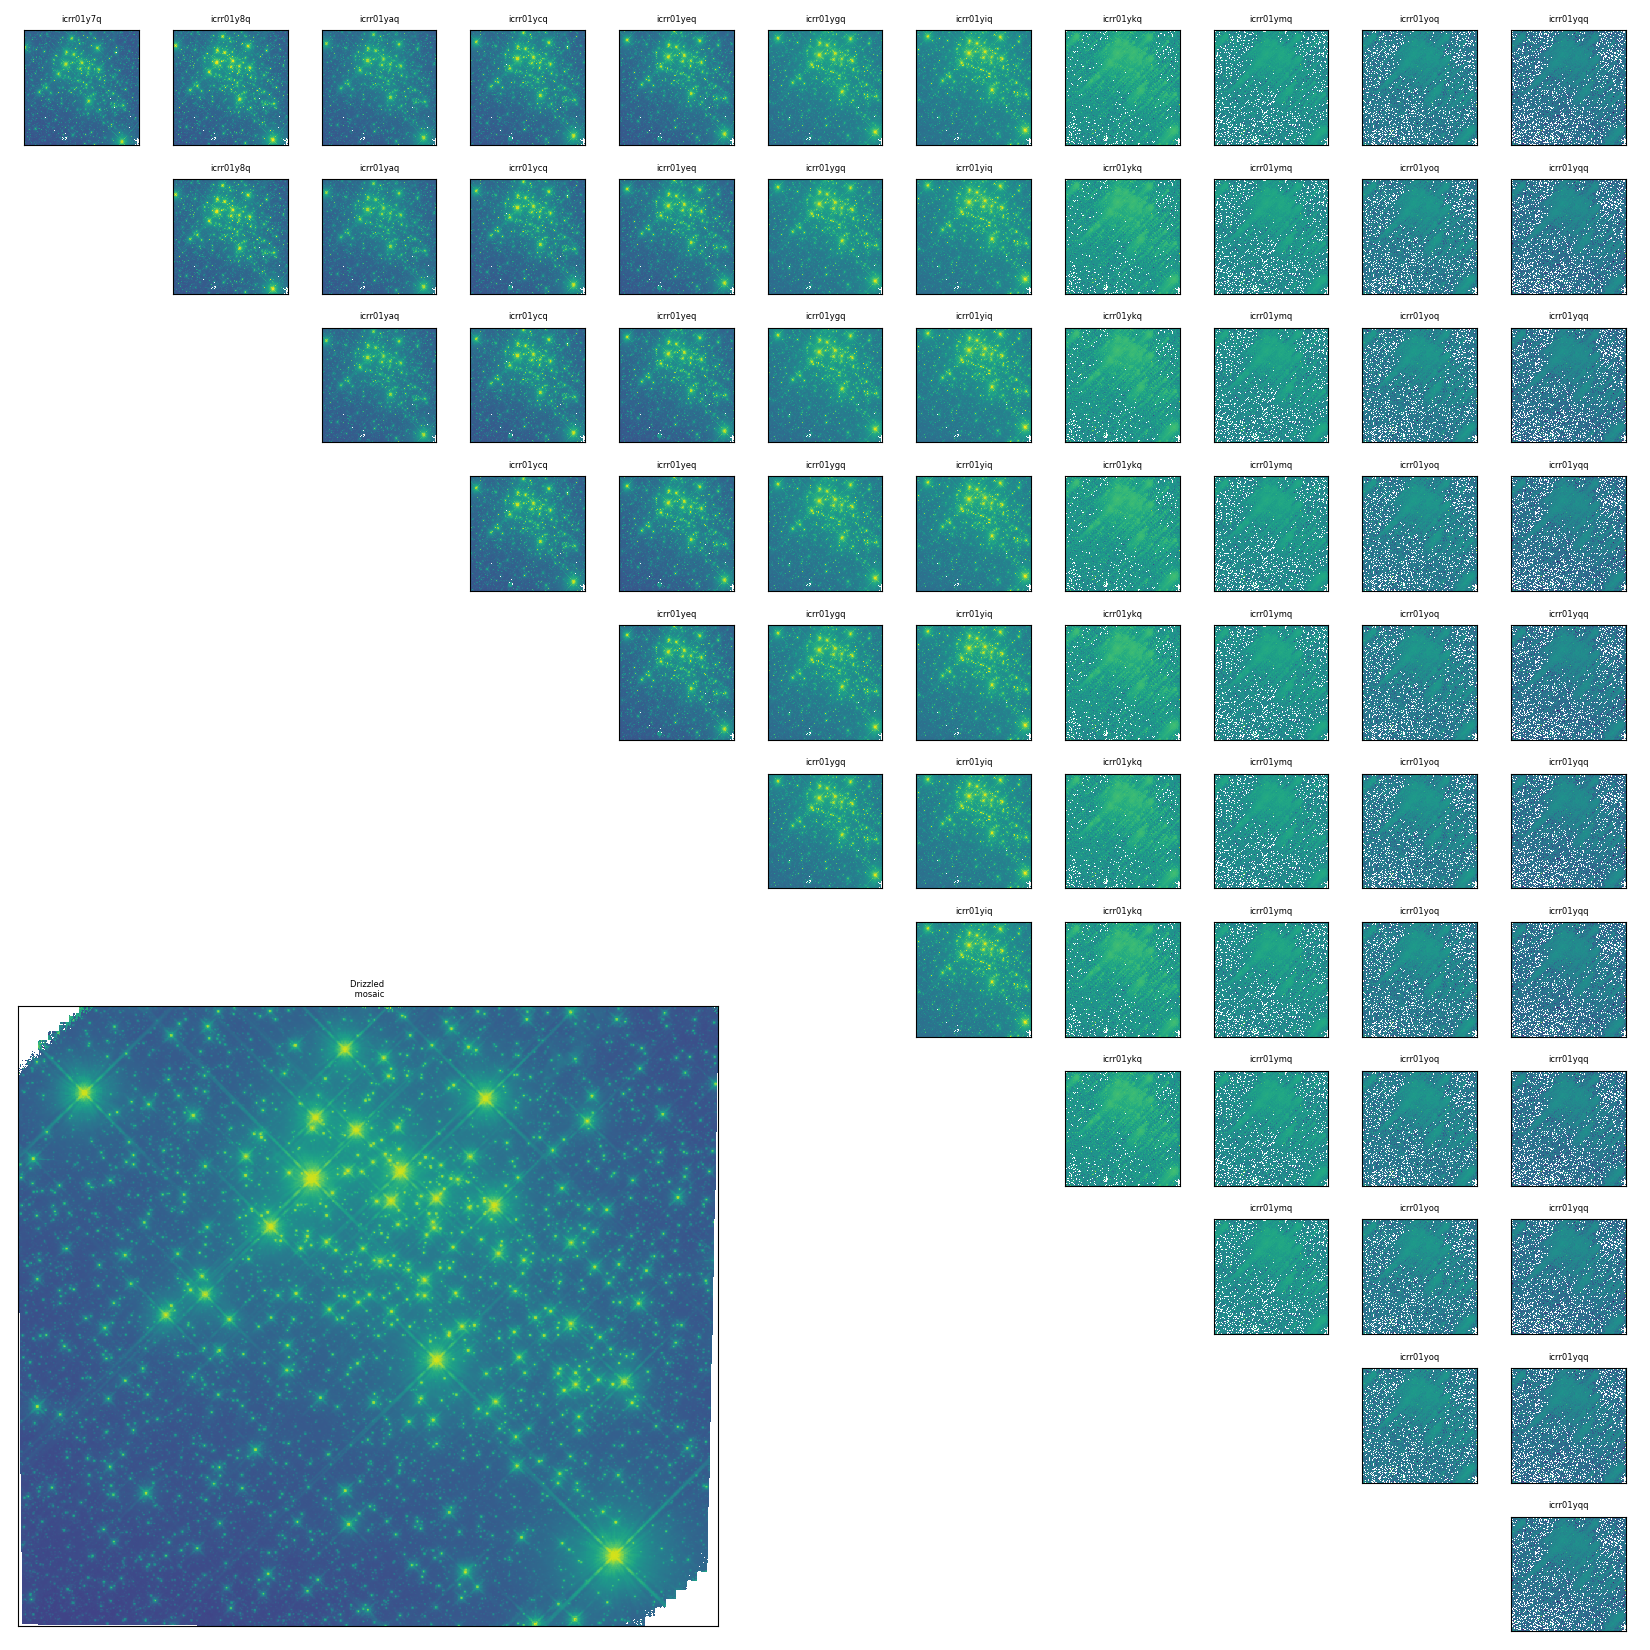

/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//Mosaic_hi_res_folder//Visit01/icrr01y7q_flt.fits clipped mean:  12.0015 AD sky:


/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log10


/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//Mosaic_hi_res_folder//Visit01/icrr01y8q_flt.fits clipped mean:  11.5323 AD sky:
/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//Mosaic_hi_res_folder//Visit01/icrr01yaq_flt.fits clipped mean:  11.9435 AD sky:
/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//Mosaic_hi_res_folder//Visit01/icrr01ycq_flt.fits clipped mean:  11.2887 AD sky:
/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//Mosaic_hi_res_folder//Visit01/icrr01yeq_flt.fits clipped mean:  11.7631 AD sky:
/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//Mosaic_hi_res_folder//Visit01/icrr01ygq_flt.fits clipped mean:  9.97466 AD sky:
/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//Mosaic_hi_res_folder//Visit01/icrr01yiq_flt.fits clipped mean:  9.6 AD sky:
/user/gennaro/Functional_work/WFC3_persisten

/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log10


In [11]:
# Choose which visit to work on

visit_index = 0
vsflts = sflts[visit_index]

# If in a hurry, shorten the list for faster analysis

vsflts = vsflts[0:11]

#plot all exposures multiple times for visualization of the selected pixels

sf=1.5
fig = plt.figure(figsize=(sf*len(vsflts),sf*len(vsflts)))

ax = []
for i,flt in enumerate(vsflts):
    im = fits.getdata(flt)
    c, low, upp = sigmaclip(im[np.isfinite(im)], 1.75,1.75)
    mn = np.nanmean(c)
    print(flt,'clipped mean: ',mn, 'AD sky:')
    j = -1
    while j < i: 
        j+=1
        ax.append(plt.subplot(len(vsflts),len(vsflts),j*len(vsflts)+1+i))
        ax[-1].imshow(np.log10(im/mn),cmap='viridis', interpolation='none', origin='lower')
        ax[-1].set_title(flt[-18:-9],fontsize=6)
        ax[-1].get_xaxis().set_ticks([])
        ax[-1].get_yaxis().set_ticks([])
        
        
# Read the mosaic file and plot it

plt.tight_layout()
mosaic = fits.open(mdir+'/F140W_Mosaic_WFC3_IR_drz.fits')

ax.append(plt.subplot(len(vsflts),len(vsflts),j*len(vsflts)+1))

pos1 = ax[-1].get_position() # get the original position 
pos2 = [pos1.x0, pos1.y0,  pos1.width * len(vsflts)/2., pos1.height * len(vsflts)/2.] 
ax[-1].set_position(pos2) # set a new position
ax[-1].get_xaxis().set_ticks([])
ax[-1].get_yaxis().set_ticks([])
        
c, low, upp = sigmaclip(mosaic[1].data[np.where(np.isfinite(mosaic[1].data))], 1.75,1.75)
mn = np.mean(c)
im = ax[-1].imshow(np.log10(mosaic[1].data/mn),cmap='viridis', interpolation='none', origin='lower')
ax[-1].set_title('Drizzled \n mosaic',fontsize=6)



In [12]:
# Create the wcs objects for the AD mosaic and flts 
# For the external flts use the wcs info in the AD 4th extension to update
# A WCS object created from the QL flts. This is needed because the WCS header of the flts copyied from QL
# may not have the up-to-date WCS that have been updated by TWREG/AD to prodcue the mosaic

flt2mosaic = list(mosaic[4].data['FILENAME']) #List of ALL the flts that contribute to the AD mosaic
w_mosaic = WCS(mosaic[1].header)

w_vsflts = []
for vsflt in vsflts:
    if (fits.getheader(vsflt,0)['IMAGETYP'] != 'EXT'):
        w_vsflts.append(WCS(fits.getheader(vsflt,1)))
    elif (fits.getheader(vsflt,0)['IMAGETYP'] == 'EXT'):

        try:
            index_element = flt2mosaic.index(vsflt[-18:])
            w = WCS(fits.getheader(vsflt,1))
            
            crval1, crval2 = mosaic[4].data['CRVAL1'][index_element],mosaic[4].data['CRVAL2'][index_element]
            cd1_1, cd1_2   = mosaic[4].data['CD1_1'][index_element],mosaic[4].data['CD1_2'][index_element]
            cd2_1, cd2_2   = mosaic[4].data['CD2_1'][index_element],mosaic[4].data['CD2_2'][index_element]
            
            w.wcs.crval = [crval1,crval2]
            w.wcs.cd    = np.array([[cd1_1, cd1_2],[cd2_1,cd2_2]])
            
        except ValueError:
            print('Flt not in the mosaic!')
            assert False
        
        w_vsflts.append(w)


<IPython.core.display.Javascript object>


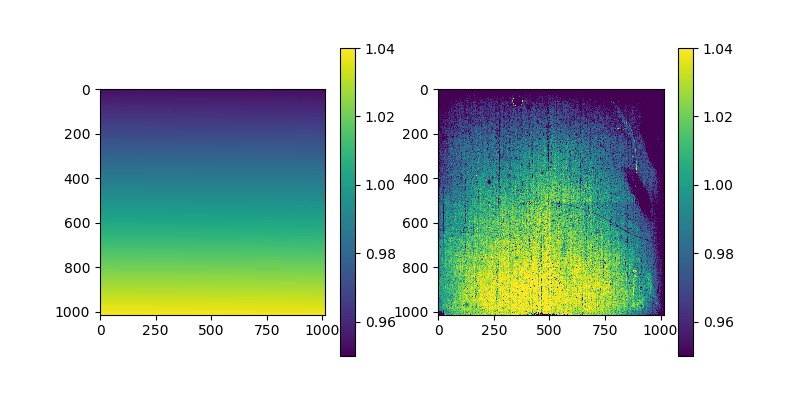

In [13]:
# Read in the pixel-area map

PAM = fits.getdata(pdir+'/Pixel_based/ir_wfc3_map.fits')

fig = plt.figure(figsize=(8,4))
fig.add_subplot(121)
plt.imshow(PAM,clim=(0.95,1.04))
plt.colorbar()

#Get the flt files to de-flatten the processed IMAs

def get_flat(ext_file):
    flatfile = fits.getval(ext_file,'PFLTFILE').replace('iref$','/grp/hst/cdbs/iref/')
    return flatfile

pflats_names = []
for flt in vsflts:
    if fits.getheader(flt)['IMAGETYP'] == 'EXT':
        pflats_names.append(get_flat(flt))
    else:
        pflats_names.append(None)
        

pflats_unique = []
for i in pflats_names:
    if i is not(None):
        if i not in pflats_unique:
            pflats_unique.append(i)

pflats = {}           
for f in pflats_unique:
    pflats[f] = fits.open(f)[1].data[5:-5,5:-5]
    

fig.add_subplot(122)
plt.imshow(pflats[pflats_names[0]],clim=(0.95,1.04))

plt.colorbar()


In [14]:
#lowlim, bs = 0., 0.2

DRZdt = mosaic[1].data
DRZ_avg_sky = np.nanmean(sigmaclip(DRZdt[np.isfinite(DRZdt)],1.75,1.75)[0])
#Dh,BDh = np.histogram(DRZdt[np.isfinite(DRZdt)],bins=np.arange(lowlim,30,bs))

#print(DRZsky,lowlim+bs*np.argmax(Dh),np.max(Dh))
#fig = plt.figure()
#plt.plot(np.log(BDh[:-1]),Dh/np.sum(Dh),c='black')
#ima_offset = 0

#for k in range(14):
#    IMAdt = (ima_scis[ima_offset+k]*ima_times[ima_offset+k] - ima_scis[ima_offset+k+1]*ima_times[ima_offset+k+1])/(ima_times[ima_offset+k] - ima_times[ima_offset+k+1])
#    IMAsky = np.nanmedian(sigmaclip(IMAdt[np.isfinite(IMAdt)],1.75,1.75)[0])
#    Ih,BIh = np.histogram(IMAdt[np.isfinite(IMAdt)],bins=np.arange(lowlim,30,bs))
#    print(IMAsky,lowlim+bs*np.argmax(Ih),np.max(Ih))
#    plt.plot(np.log(BIh[:-1]),Ih/np.sum(Ih))


In [15]:
#From the current AD mosaic, get the sky values offsets that need to be used in the flts

flt2mosaic = list(mosaic[4].data['FILENAME']) #List of ALL the flts that contribute to the AD mosaic
MDRIZSKYs = []

for vsflt in vsflts:
    try:
        index_element = flt2mosaic.index(vsflt[-18:])
        MDRIZSKYs.append(mosaic[4].data['MDRIZSKY'][index_element])
    except ValueError:
        MDRIZSKYs.append(0.)
    print(vsflt,MDRIZSKYs[-1])

/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//Mosaic_hi_res_folder//Visit01/icrr01y7q_flt.fits 0.0
/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//Mosaic_hi_res_folder//Visit01/icrr01y8q_flt.fits 0.0952708118571
/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//Mosaic_hi_res_folder//Visit01/icrr01yaq_flt.fits 0.211480815321
/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//Mosaic_hi_res_folder//Visit01/icrr01ycq_flt.fits 0.231527093651
/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//Mosaic_hi_res_folder//Visit01/icrr01yeq_flt.fits 0.471968692904
/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//Mosaic_hi_res_folder//Visit01/icrr01ygq_flt.fits 0.606488047397
/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//Mosaic_hi_res_folder//Visit01/icrr01yiq_flt.fits 0.275159922519
/u

In [16]:
#Preprocess darks- determine corresponding superdark
def update_dark(vsflt):
    if 'N/A' in fits.getval(vsflt,'DARKFILE',ext=0):
        fits.setval(vsflt,'DARKCORR',value='PERFORM',ext=0)
        errors = bestrefs.BestrefsScript('BestrefsScript --update-bestrefs -s 1 -f ' + vsflt)()
        
def get_superdark_plane(darkfile, nsamp):
    darkfile = darkfile.replace('iref$','/grp/hst/cdbs/iref/')
    hdu = fits.open(darkfile)
    planes = []
    for k in range(nsamp):
        samp = 16-nsamp+k+1
        if (hdu[1].header['BUNIT'] == 'COUNTS/S'):
            planes.append(hdu['SCI',samp].data)
        else:
            if samp != 16:
                planes.append( (hdu['SCI',samp].data - hdu['SCI',16].data )/hdu['TIME',samp].header['PIXVALUE'])
            else:
                planes.append( 0.*(hdu['SCI',samp].data))
            
    hdu.close()
    return planes


In [17]:
#In order to match the image coordinates with the astropy convention,
#the first coordinate in the following numpy array is the y, the second the x 

gn_im = np.ones([1014,1014])

hd = fits.open(vsflts[0])

gn_im[0:507,0:507] = hd[0].header['ATODGNA'] #2.252  #q1
gn_im[507:,0:507]  = hd[0].header['ATODGNB'] #2.203  #q2
gn_im[507:,507:]   = hd[0].header['ATODGNC'] #2.188  #q3
gn_im[0:507,507:]  = hd[0].header['ATODGND'] #2.265  #q4

print(fits.open(vsflts[8])[0].header['*TODGN*'])

ATODGNA =        2.3399999E+00 / calibrated gain for amplifier A                ATODGNB =        2.3699999E+00 / calibrated gain for amplifier B                ATODGNC =        2.3099999E+00 / calibrated gain for amplifier C                ATODGND =        2.3800001E+00 / calibrated gain for amplifier D                END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [18]:
# Create the numpy arrays containg the ima and flt data as well
# as the arrays of metadata.
# Also subtract the MDRIZSKY from the flt for a 1-to-1 comaprison with the AD mosaic
# Also bring the darks into e/s


ima_scis  = []
ima_errs  = []
ima_dqs   = []
ima_times = [] 
ima_avg_sky  = []

flts      = []
flts_dqs  = []
flts_avg_sky  = []


tendMJDs  = []
tstrMJDs  = []
imtyps    = []
nsamps    = []
sampseqs  = []

ima_offset = 0

for vsflt,MDS in zip(vsflts,MDRIZSKYs):
    print('Appending '+vsflt+' to the datacube')

    ima = fits.open(vsflt.replace('_flt','_ima'))
    nsamps.append(ima[0].header['NSAMP'])
    sampseqs.append(ima[0].header['SAMP_SEQ'])

    hdr = fits.getheader(vsflt)
    if (hdr['IMAGETYP'] == 'DARK'):
        update_dark(vsflt)
        print(fits.getval(vsflt,'DARKFILE'))
        superdark_planes = get_superdark_plane(fits.getval(vsflt,'DARKFILE'),nsamps[-1])
    
    flt = fits.open(vsflt)
    
    
    if (flt[1].header['BUNIT'] == 'COUNTS/S'):
        fdt = flt['SCI'].data*flt[0].header['CCDGAIN']
    elif (flt[1].header['BUNIT'] == 'ELECTRONS/S'):
        fdt = flt['SCI'].data
    else:
        print('BUNITS not supported')
        assert False
    
    
    for k in range(nsamps[-1]):
        if (ima['SCI',k+1].header['BUNIT'] == 'COUNTS/S' and (hdr['IMAGETYP'] == 'DARK')):
            dark_sub_ima = ima['SCI',k+1].data-superdark_planes[k]
#            imas = dark_sub_ima[5:-5,5:-5]*ima[0].header['CCDGAIN']
#            imae = ima['ERR',k+1].data[5:-5,5:-5]*ima[0].header['CCDGAIN']
            imas = dark_sub_ima[5:-5,5:-5]*gn_im
            imae = ima['ERR',k+1].data[5:-5,5:-5]*gn_im

        elif (ima['SCI',k+1].header['BUNIT'] == 'COUNTS/S'):
            imas = ima['SCI',k+1].data[5:-5,5:-5]*ima[0].header['CCDGAIN']
            imae = ima['ERR',k+1].data[5:-5,5:-5]*ima[0].header['CCDGAIN']
            
        elif (ima['SCI',k+1].header['BUNIT'] == 'ELECTRONS/S'):
            imas = ima['SCI',k+1].data[5:-5,5:-5]
            imae = ima['ERR',k+1].data[5:-5,5:-5]
        else:
            print('BUNITS not supported')
            assert False
                
        ima_scis.append(imas)
        ima_errs.append(imae)
        ima_dqs.append(ima['DQ',k+1].data[5:-5,5:-5])
        ima_times.append(ima['TIME',k+1].header['PIXVALUE'])

#Avergae sky computation
    if (hdr['IMAGETYP'] == 'EXT'):
        afs = np.nanmean(sigmaclip(fdt[np.isfinite(fdt)],1.75,1.75)[0])
        print('Avg flt sky:',afs)
        flts_avg_sky.append(afs)
    else:
        flts_avg_sky.append(0.)
    
    
    for k in range(nsamps[-1]):    
        if (hdr['IMAGETYP'] == 'EXT'):
            if k == (nsamps[-1] - 1):
                ima_avg_sky.append(0.)
            else:
                meancurr_ima = (ima_scis[ima_offset+k]*ima_times[ima_offset+k] - ima_scis[ima_offset+k+1]*ima_times[ima_offset+k+1])/(ima_times[ima_offset+k] - ima_times[ima_offset+k+1])
                ais = np.nanmean(sigmaclip(meancurr_ima[np.isfinite(meancurr_ima)],1.75,1.75)[0])
                ima_avg_sky.append(ais)
                print('Avg ima sky:',ais)
        else:
            ima_avg_sky.append(0.)
        
    ima_offset += nsamps[-1]

    tendMJDs.append(flt[0].header['EXPEND'])
    tstrMJDs.append(flt[0].header['EXPSTART'])
    imtyps.append(flt[0].header['IMAGETYP'])
    flts.append(fdt)
    flts_dqs.append(flt['DQ'].data)
    
    flt.close()
    ima.close()
    

print('Done1')
ima_scis  = np.asarray(ima_scis)
print('Done2')
ima_errs  = np.asarray(ima_errs)
print('Done3')
ima_times = np.asarray(ima_times)
print('Done4')
ima_dqs = np.asarray(ima_dqs)
print('Done5')
flts      = np.asarray(flts)
print('Done6')
flts_dqs = np.asarray(flts_dqs)
print('Done7')
flts_avg_sky =  np.asarray(flts_avg_sky)
print('Done8')
tendMJDs  = np.asarray(tendMJDs)
print('Done9')
tstrMJDs  = np.asarray(tstrMJDs)
print('Done10')
imtyps    = np.asarray(imtyps)
print('Done11')
nsamps    = np.asarray(nsamps)
print('Done12')
ima_avg_sky   = np.asarray(ima_avg_sky)
print('Done13')


Appending /user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//Mosaic_hi_res_folder//Visit01/icrr01y7q_flt.fits to the datacube
Avg flt sky: 12.0015
Avg ima sky: 12.0274
Avg ima sky: 11.9105
Avg ima sky: 12.1168
Avg ima sky: 11.9682
Avg ima sky: 11.9778
Avg ima sky: 12.0386
Avg ima sky: 12.1133
Avg ima sky: 12.1282
Avg ima sky: 12.1367
Avg ima sky: 12.111
Avg ima sky: 12.1373
Avg ima sky: 12.2563
Avg ima sky: 12.1154
Avg ima sky: 12.0866
Avg ima sky: 15.8409
Appending /user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//Mosaic_hi_res_folder//Visit01/icrr01y8q_flt.fits to the datacube
Avg flt sky: 11.5323
Avg ima sky: 11.4616
Avg ima sky: 11.7308
Avg ima sky: 11.5828
Avg ima sky: 11.6552
Avg ima sky: 11.7286
Avg ima sky: 11.7625
Avg ima sky: 11.8106
Avg ima sky: 11.725
Avg ima sky: 11.8271
Avg ima sky: 11.7831
Avg ima sky: 11.7433
Avg ima sky: 11.8938
Avg ima sky: 11.8059
Avg ima sky: 11.8741
Avg ima sky: 15.2548
Appending /user/genn

In [19]:
#Define the stimuli e-/s level to identify the ramps

lev_u = np.inf
lev_d = 5.5e5

# Define the pixel grid (to trasform indices in x,y positions)
xgrid,ygrid = np.meshgrid( np.arange(fits.getdata(vsflts[0],1).shape[1]) ,np.arange(fits.getdata(vsflts[0],1).shape[0]))
dxgrid,dygrid = np.meshgrid( np.arange(mosaic[1].data.shape[1]) ,np.arange(mosaic[1].data.shape[0]))

drz_finite = np.isfinite(mosaic[1].data)

msky_d = np.nanmean(sigmaclip(mosaic[1].data[drz_finite],1.75,1.75)[0])
ssky_d = np.nanstd(sigmaclip(mosaic[1].data[drz_finite],2.5,2.5)[0])
mask_sky_contam = (mosaic[1].data <msky_d+1*ssky_d) & (mosaic[1].data >msky_d-2*ssky_d) & drz_finite

skyrad_o = 15
skyrad_i = 3
lookback = None
psf = 0.2
numcores = 8

/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


In [20]:
#before running the big step perform garbage collection
gc.collect()

df = pd.DataFrame()
cols = ['Stim','EXPTIME_stim','xpix','ypix','tfromstim','deltat','Read index','NSAMP','meancurr','stdvcurr','Ind_stim','Ind_pers','Stim_type','Pers_type','DQ_stim','DQ_pers']

mypool = Pool(numcores)

# Parallelized version
for istim,stim in enumerate(vsflts[:-1]):

    print('**********************')
    print('Doing: ',stim)

    if imtyps[istim] == 'EXT':
    
        icount    = find_ramps(istim,flts,lev_u,lev_d,lb=lookback,PAM=PAM,psf=psf)
    
        nz     = np.nonzero(icount)    
        nnexts = icount[nz]
    
        nlines = 0
        for nnext in nnexts:
            nlines = nlines+np.sum((nsamps-1)[istim+1:istim+1+nnext])

        print('Number of entries: ',nlines)
        modulus = np.trunc(nlines/10)
    
        if (nlines > 0) :
            flt_big_index = []
            for nz0,nz1,nnext in list(zip(nz[0],nz[1],nnexts)):
                prod = product([nz0], [nz1], range(1,nnext+1,1),[istim])
                flt_big_index += list(prod)
    
            derp = mypool.starmap(get_sky_and_indices, flt_big_index)
            ima_big_index = []
            for block in derp:
                ima_big_index += block
        
            biglist = mypool.starmap(get_pixel_values,zip(ima_big_index, [istim]*nlines, [PAM]*nlines))
            df = df.append(pd.DataFrame(biglist,columns=cols),ignore_index=True)
 

**********************
Doing:  /user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//Mosaic_hi_res_folder//Visit01/icrr01y7q_flt.fits
Pixels with potentially right stimuli: 25586
Pixels with really right stimuli: 25586
Pixels with ramps extending for at least 1  exposures: 1713
Pixels with ramps extending for at least 2  exposures: 1254
Pixels with ramps extending for at least 3  exposures: 984
Pixels with ramps extending for at least 4  exposures: 791
Pixels with ramps extending for at least 5  exposures: 639
Pixels with ramps extending for at least 6  exposures: 517
Pixels with ramps extending for at least 7  exposures: 517
Pixels with ramps extending for at least 8  exposures: 517
Pixels with ramps extending for at least 9  exposures: 517
Pixels with ramps extending for at least 10  exposures: 517
Number of entries:  117939
**********************
Doing:  /user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence//Mosaic_hi_res_folder//Vi

In [21]:
df.head()

,Stim,EXPTIME_stim,xpix,ypix,tfromstim,deltat,Read index,NSAMP,meancurr,stdvcurr,Ind_stim,Ind_pers,Stim_type,Pers_type,DQ_stim,DQ_pers
0,804955.269599,352.960416,552,0,418.987126,25.00051,15,16,0.124687,3.486494,0,1,EXT,EXT,0,0
1,804955.269599,352.960416,552,0,393.986616,25.00052,14,16,0.710408,3.387132,0,1,EXT,EXT,0,0
2,804955.269599,352.960416,552,0,368.986096,25.00052,13,16,0.444138,3.281984,0,1,EXT,EXT,0,0
3,804955.269599,352.960416,552,0,343.985576,25.00052,12,16,2.253748,3.164758,0,1,EXT,EXT,0,0
4,804955.269599,352.960416,552,0,318.985056,25.00052,11,16,0.726921,3.041260,0,1,EXT,EXT,0,0


In [22]:
# Rearrange the dataframe to save only non-redundant info

df2 = df.set_index(['xpix', 'ypix','Ind_stim','Stim','EXPTIME_stim','Stim_type','DQ_stim'])
df2.head()

tfromstim  \
xpix ypix Ind_stim Stim          EXPTIME_stim Stim_type DQ_stim               
552  0    0        804955.269599 352.960416   EXT       0        418.987126   
                                                        0        393.986616   
                                                        0        368.986096   
                                                        0        343.985576   
                                                        0        318.985056   

                                                                   deltat  \
xpix ypix Ind_stim Stim          EXPTIME_stim Stim_type DQ_stim             
552  0    0        804955.269599 352.960416   EXT       0        25.00051   
                                                        0        25.00052   
                                                        0        25.00052   
                                                        0        25.00052   
                                                        0        25.00052   

                                                                 Read index  \
xpix ypix Ind_stim Stim          EXPTIME_stim Stim_type DQ_stim               
552  0    0        804955.269599 352.960416   EXT       0                15   
                                                        0                14   
                                                        0                13   
                                                        0                12   
                                                        0                11   

                                                                 NSAMP  \
xpix ypix Ind_stim Stim          EXPTIME_stim Stim_type DQ_stim          
552  0    0        804955.269599 352.960416   EXT       0           16   
                                                        0           16   
                                                        0           16   
                                                        0           16   
                                                        0           16   

                                                                 meancurr  \
xpix ypix Ind_stim Stim          EXPTIME_stim Stim_type DQ_stim             
552  0    0        804955.269599 352.960416   EXT       0        0.124687   
                                                        0        0.710408   
                                                        0        0.444138   
                                                        0        2.253748   
                                                        0        0.726921   

                                                                 stdvcurr  \
xpix ypix Ind_stim Stim          EXPTIME_stim Stim_type DQ_stim             
552  0    0        804955.269599 352.960416   EXT       0        3.486494   
                                                        0        3.387132   
                                                        0        3.281984   
                                                        0        3.164758   
                                                        0        3.041260   

                                                                 Ind_pers  \
xpix ypix Ind_stim Stim          EXPTIME_stim Stim_type DQ_stim             
552  0    0        804955.269599 352.960416   EXT       0               1   
                                                        0               1   
                                                        0               1   
                                                        0               1   
                                                        0               1   

                                                                Pers_type  \
xpix ypix Ind_stim Stim          EXPTIME_stim Stim_type DQ_stim             
552  0    0        804955.269599 352.960416   EXT       0             EXT   
                                                

In [23]:
iuniq  = df2.index.unique()
df2['Uniq_multiindex'] = np.empty(len(df2),dtype=np.int_)

print('Number of points:',len(df))
print('Number of unique ramps:',len(iuniq))

for i,ind in enumerate(iuniq):
    if (i%1000 == 0):
        print(i)
    df2.loc[ind,'Uniq_multiindex'] = i

Number of points: 1465206
Number of unique ramps: 23630
0


/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/zmqshell.py:533: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000


In [24]:
#Make sure that the data types are set to more space-efficient ones

df2['Ind_pers'] = df2['Ind_pers'].astype(np.uint8)
df2['Read index'] = df2['Read index'].astype(np.uint8)
df2['NSAMP'] = df2['NSAMP'].astype(np.uint8)
df2[['tfromstim','deltat','meancurr','stdvcurr']] = df2[['tfromstim','deltat','meancurr','stdvcurr']].astype(np.float32)
df2['Uniq_multiindex'] = df2['Uniq_multiindex'].astype(np.uint32)


In [25]:
# The dataframe mapping the uniqe ramps indices
df_lookup = df2[['Uniq_multiindex']].copy().drop_duplicates()
df_lookup.head()

,,,,,,,Uniq_multiindex
xpix,ypix,Ind_stim,Stim,EXPTIME_stim,Stim_type,DQ_stim,
552,0,0,8.049553e+05,352.960416,EXT,0,0
553,0,0,1.374594e+06,352.960416,EXT,0,1
617,0,0,5.937259e+05,352.960416,EXT,8,2
618,0,0,8.838944e+05,352.960416,EXT,0,3
619,0,0,8.233801e+06,352.960416,EXT,0,4


In [26]:
# The dataframe with persistence values

df_values=pd.DataFrame()
df_values['tfromstim']       = df2['tfromstim'].values 
df_values['deltat']          = df2['deltat'].values 
df_values['Read index']      = df2['Read index'].values 
df_values['meancurr']        = df2['meancurr'].values 
df_values['stdvcurr']        = df2['stdvcurr'].values 
df_values['NSAMP']           = df2['NSAMP'].values 
df_values['Ind_pers']        = df2['Ind_pers'].values 
df_values['Pers_type']       = df2['Pers_type'].values 
df_values['DQ_pers']         = df2['DQ_pers'].values 
df_values['Uniq_multiindex'] = df2['Uniq_multiindex'].values 

df_values.head()

,tfromstim,deltat,Read index,meancurr,stdvcurr,NSAMP,Ind_pers,Pers_type,DQ_pers,Uniq_multiindex
0,418.987122,25.000509,15,0.124687,3.486495,16,1,EXT,0,0
1,393.986603,25.000521,14,0.710408,3.387132,16,1,EXT,0,0
2,368.986084,25.000521,13,0.444138,3.281984,16,1,EXT,0,0
3,343.985565,25.000521,12,2.253748,3.164758,16,1,EXT,0,0
4,318.985046,25.000521,11,0.726921,3.041260,16,1,EXT,0,0


In [27]:
df_values.to_hdf(sdir+'DF_extonly.h5', 'Visit'+'{:0>2}'.format(str(visit_index+1))+'_values', mode='a',format = 't')
df_lookup.to_hdf(sdir+'DF_extonly.h5', 'Visit'+'{:0>2}'.format(str(visit_index+1))+'_lookup', mode='a',format = 't')


In [28]:
stims = flts[0:7]
offset = np.sum(nsamps[0:7])
pers = ima_scis[offset:offset+13]
pers_times = ima_times[offset:offset+13]

<IPython.core.display.Javascript object>


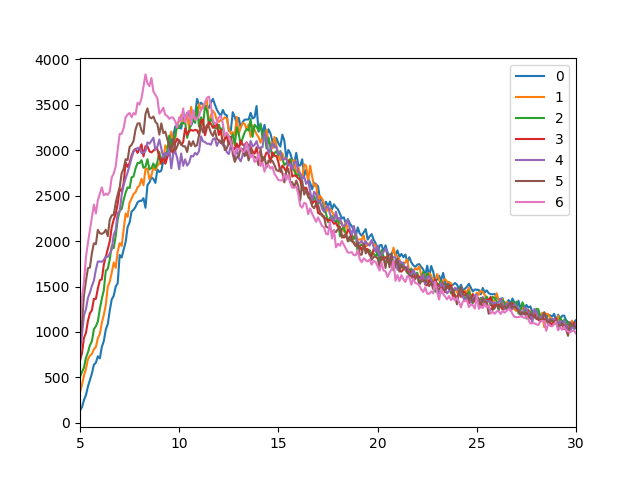

(5, 30)

In [29]:
fig=plt.figure()
for i,stim in enumerate(stims):
    Dh,BDh = np.histogram(stim[np.isfinite(stim)],bins=np.arange(5,50,0.1))
    plt.plot(BDh[:-1],Dh,label=i)

#Dh,BDh = np.histogram(stims[np.isfinite(stims)],bins=np.arange(5,50,0.1))
#plt.plot(BDh[:-1],Dh/7,label='ALL',c='black',linewidth=4)

plt.legend()
plt.xlim(5,30)

In [30]:
print(pers_times)

[ 599.23218    499.23187    399.23157    299.23126    199.23096     99.230637
   49.230225    24.229715    11.729164     8.7968731    5.8645821
    2.932291     0.       ]


<IPython.core.display.Javascript object>


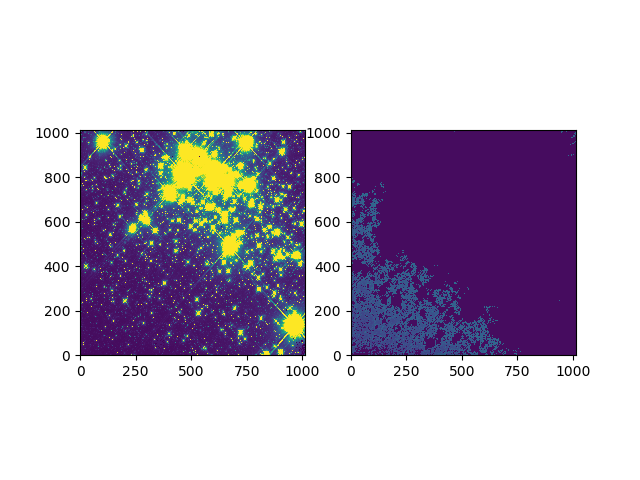

149644


<IPython.core.display.Javascript object>


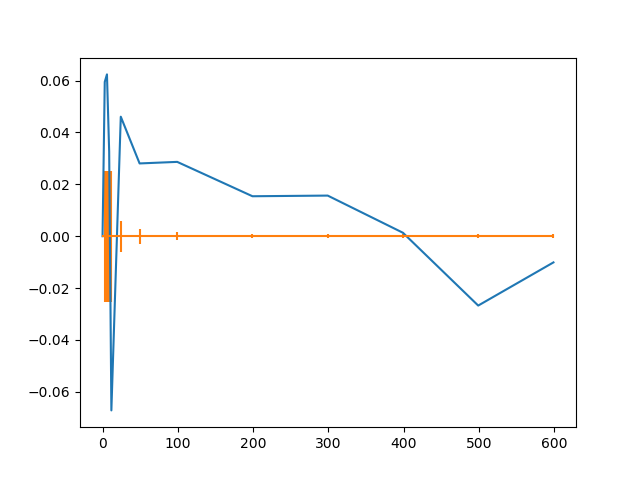

<Container object of 3 artists>

In [31]:
sky_msk  = np.ones_like(stim[0],dtype=np.bool_)
for stim in stims[6:]:
    sky_msk = sky_msk & (stim <10) & (stim >5) 


fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(stims[6],cmap='viridis', interpolation='none', origin='lower',clim=[-1,200])

flgstim = stims[6]*sky_msk
ax2 = fig.add_subplot(122)
ax2.imshow(flgstim,cmap='viridis', interpolation='none', origin='lower',clim=[-1,30])

print(np.sum(sky_msk))

rn = 20

mean_dark = np.zeros(13)
rn_rate = np.zeros(13)

for i in range(12):
    pok_e = pers[i,:,:][np.where(sky_msk == True)]
    pok_s = pers[i+1,:,:][np.where(sky_msk == True)]
    
    te = pers_times[i]
    ts = pers_times[i+1]
    tdenom    = te-ts
    meancurr  = (pok_e*te - pok_s*ts)/tdenom

    drk_good = sigmaclip(meancurr,2.5,2.5)[0]
    mean_dark[i] = np.mean(drk_good)
    rn_rate[i] = np.sqrt(2)*rn/tdenom/np.sqrt(drk_good.size)
    

    
fig2 = plt.figure()
ax   = fig2.add_subplot(111)
ax.plot(pers_times,mean_dark)
ax.errorbar(pers_times,np.zeros_like(pers_times),yerr=rn_rate)